In [1]:
import re
import json
import pandas as pd
import csv
import os
import numpy as np
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm 
from pyvis.network import Network
import networkx as nx
import plotly.express as px
from datetime import datetime,timedelta
import math

high_colors = ['#648FFF',  '#DC267F', '#FE6100', '#FFB000'] #'#785EF0',
low_colors = ['#31a1ae', '#507d87', '#d73e41', '#ff5c61', '#ffa6b0']
sns.set_palette(sns.color_palette(high_colors))
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
purple   = matplotlib.colors.to_rgba("#800080")
purple_op = matplotlib.colors.to_rgba("#800080", alpha=0.5)
purple_act = matplotlib.colors.to_rgba("#800080", alpha=0.3)

blue   = matplotlib.colors.to_rgba("#0000FF")
blue_op = matplotlib.colors.to_rgba("#0000FF", alpha=0.6)
blue_act = matplotlib.colors.to_rgba("#0000FF", alpha=0.4)

red   = matplotlib.colors.to_rgba("#DC143C")
red_op = matplotlib.colors.to_rgba("#DC143C", alpha=0.5)
red_act = matplotlib.colors.to_rgba("#DC143C", alpha=0.3)

green   = matplotlib.colors.to_rgba("#006400")
green_op = matplotlib.colors.to_rgba("#006400", alpha=0.5)
green_act = matplotlib.colors.to_rgba("#006400", alpha=0.3)

yellow   = matplotlib.colors.to_rgba("#BBF90F")
underst = matplotlib.colors.to_rgba("#FFD700")

In [3]:
def get_action_category(action):
    if action in ['tree', 'define', 'reference']:
        return 'navigation'
    elif action in ['mark', 'unmark']:
        return 'editing'
    else:
        return 'user interface' # move-node , move-leaf, hide file, UI

In [4]:
df_actions = pd.read_csv('../data/actions.csv')
df_interruptions = pd.read_csv('../data/interruptions.csv')

In [5]:
df_actions['time'] = df_actions['time'].apply(pd.to_datetime)
df_actions['time_dup'] = df_actions['time_dup'].apply(pd.to_datetime)

df_interruptions['start'] = df_interruptions['start'].apply(pd.to_datetime)
df_interruptions['end'] = df_interruptions['end'].apply(pd.to_datetime)

In [6]:
df_times_min = df_actions.groupby('user').agg({'time':'min'}).reset_index()
df_times_min['min'] = df_times_min['time']
df_times_max = df_actions.groupby('user').agg({'time':'max'}).reset_index()
df_times_max['max'] = df_times_max['time']
df_times = pd.merge(df_times_min[['user', 'min']], df_times_max[['user', 'max']], left_on='user', right_on='user', how='left')

# calculate totol duration in minutes for each user
df_times['total_duration'] = df_times['max'] - df_times['min']
df_times['total_duration'] = df_times['total_duration'].apply(lambda d: d.total_seconds()/60)

In [7]:
df_interruptions['seconds'] = df_interruptions['interrupt_duration'].apply(lambda l: int(l)*60)

In [8]:
# associate each event to the assigned activity categoty
df_actions['action_category'] = df_actions.type.apply(lambda x: get_action_category(x))

In [9]:
df_actions['time'] = pd.to_datetime(df_actions['time'])
f = lambda x: x.diff().dt.total_seconds().gt(1).cumsum()
df_actions['g'] =  df_actions.groupby(["user", 'action_category'])['time'].transform(f)

In [10]:
df_dur = df_actions.groupby(['user', 'action_category', 'g']).agg({'time':'first', 'time_dup':'last', 'type': 'size'}).reset_index() 

In [11]:
df_dur['delta'] = (df_dur['time_dup'] - df_dur['time']).dt.total_seconds()

In [12]:
df_dur = df_dur[['user',  'action_category', 'time', 'time_dup', 'delta']] 

In [13]:
df_interruptions['action_category'] = 'interruption'
df_interruptions['time'] = df_interruptions.start
df_interruptions['time_dup'] = df_interruptions.end
df_interruptions['delta'] = (df_interruptions.end - df_interruptions.start).dt.total_seconds()

## Add Task boundaries

In [14]:
lst_activity = []
for group, df_group in df_dur.groupby(['user']): 
    df_group = df_group.sort_values(by='time')
    df_group['cum_act'] = (df_group['action_category'] != df_group['action_category'].shift()).cumsum()
    df_group['cum_delta'] = ((df_group.time - df_group.time.shift()).dt.total_seconds()> 10*60).cumsum()

    df_act = df_group.groupby(['user', 'action_category', 'cum_act', 'cum_delta'
                              ]).agg({'time':'first', 'time_dup':'last'}).reset_index() 
    lst_activity.append(df_act[['user', 'action_category', 'time','time_dup']]) 
    
df_activity = pd.concat(lst_activity)

In [15]:
df_activity = pd.concat([df_activity, df_interruptions[['user', 'action_category', 'time', 'time_dup']]])

In [16]:
df_activity['delta'] = (df_activity['time_dup'] - df_activity['time']).dt.total_seconds()
df_activity['delta'] = df_activity.apply(lambda row: 0 if row['action_category'] in  ['start', 'end'] else row['delta'], axis=1)

In [17]:
interrupt_lst = []
for user in df_activity.user.unique():
    df_tt = df_activity[(df_activity.user == user)].sort_values(by=['time'])
    df_tt['bet_time'] = (df_tt['time'] - df_tt['time_dup'].shift()).dt.total_seconds()
    df_tt['bet_min'] = df_tt['bet_time']/60
    
    df_tt['bet_start_time'] = df_tt['time_dup'].shift()

    df_between = df_tt[['user', 'action_category', 'time', 'bet_time', 'bet_start_time']][(df_tt.bet_time > 1) & (df_tt.bet_min <=10)
                                                                                         ]
    df_idle = df_tt[['user', 'action_category', 'time', 'bet_time', 'bet_start_time']][(df_tt.bet_min > 10)]
    
    df_between.rename(columns={"time": "time_dup", "bet_start_time": "time", 'bet_time':'delta'}, inplace=True)
    df_between['action_category'] = 'understanding'
    
    df_idle.rename(columns={"time": "time_dup", "bet_start_time": "time", 'bet_time':'delta'}, inplace=True)
    df_idle['action_category'] = 'idle'
    
    df_dur = pd.concat([df_dur, df_between, df_idle
                       ])

In [18]:
df_users = df_actions.groupby(['user', 'group']).size().reset_index(name='count')
dict_users = {}
for k, row in df_users.iterrows():
    dict_users[row['user']] = row['group']

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


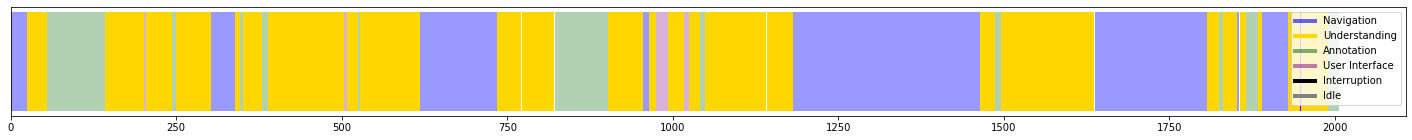

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


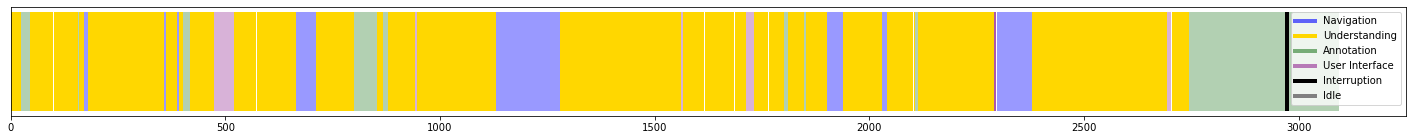

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


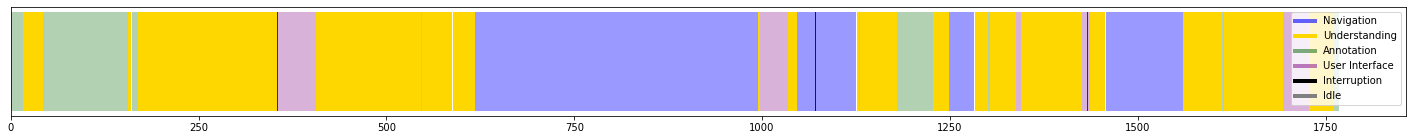

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


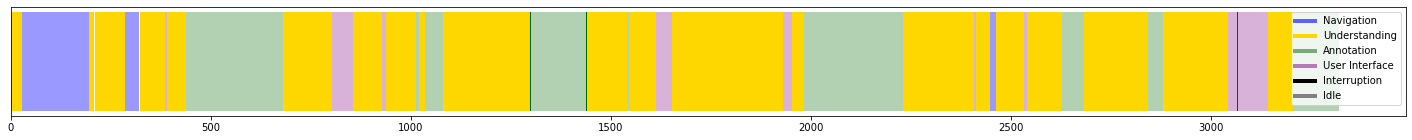

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


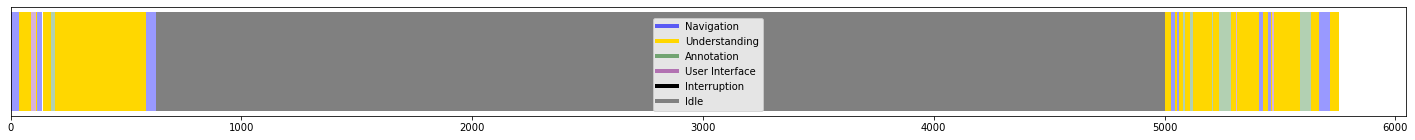

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


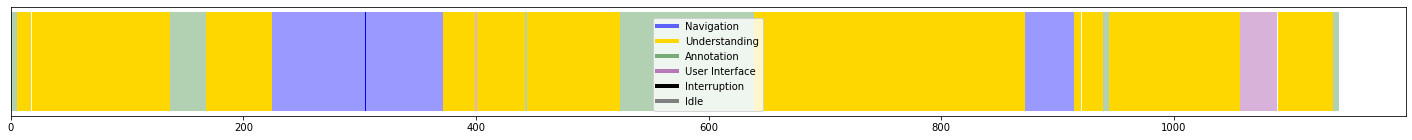

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


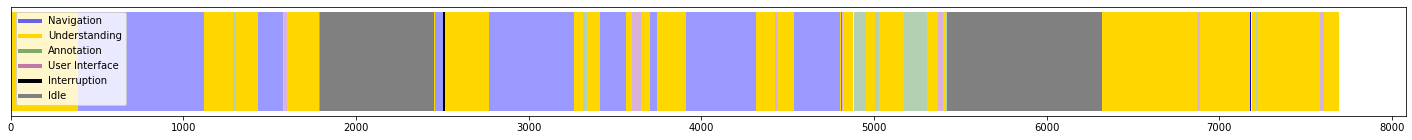

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


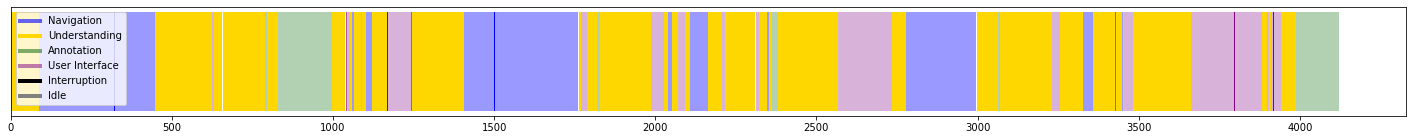

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


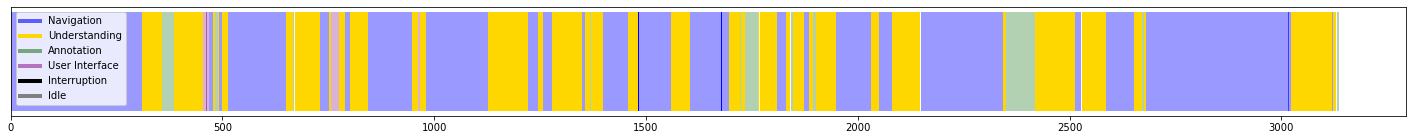

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


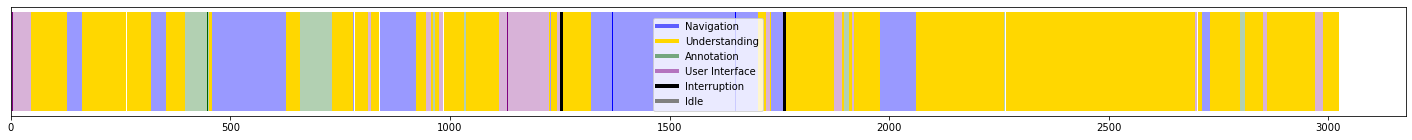

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


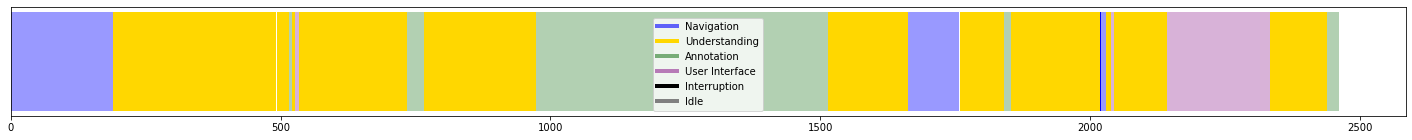

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


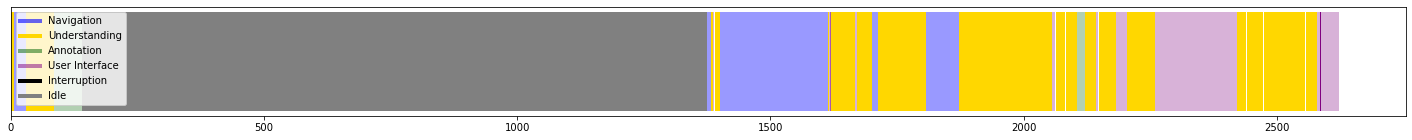

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


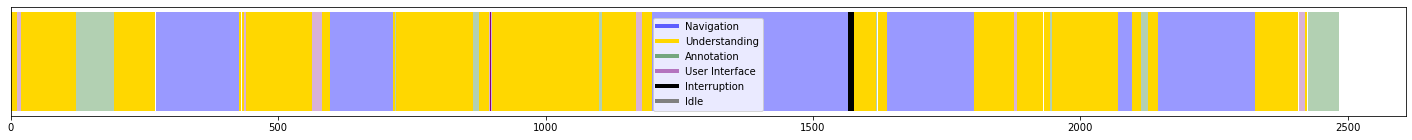

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


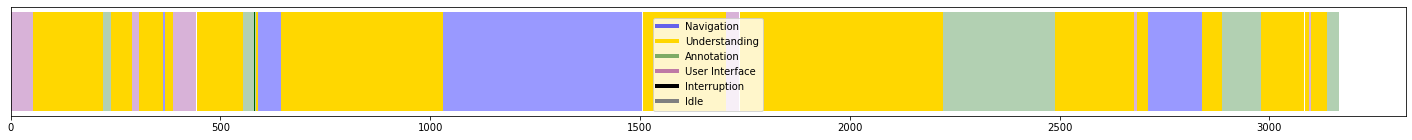

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


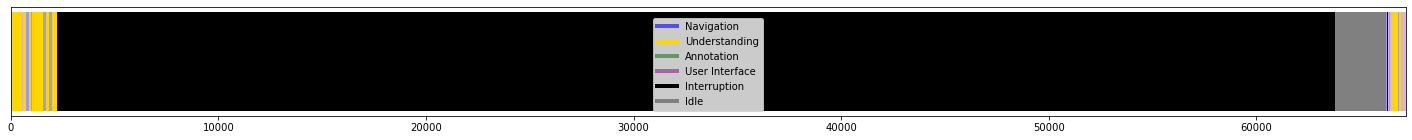

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


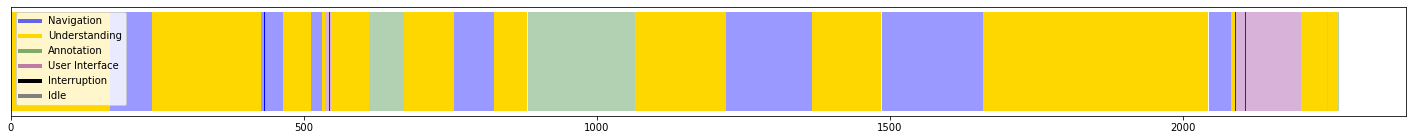

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


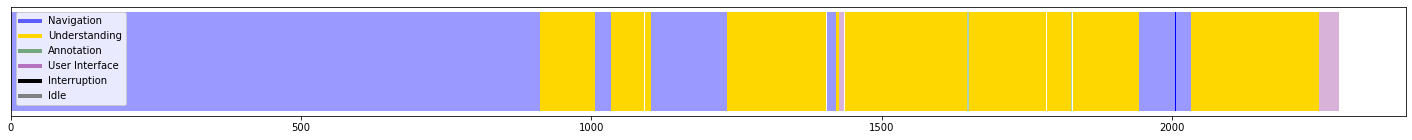

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


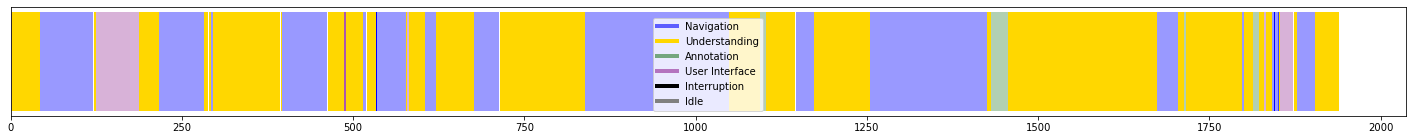

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


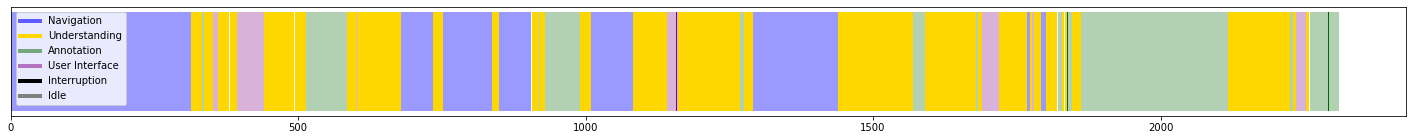

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


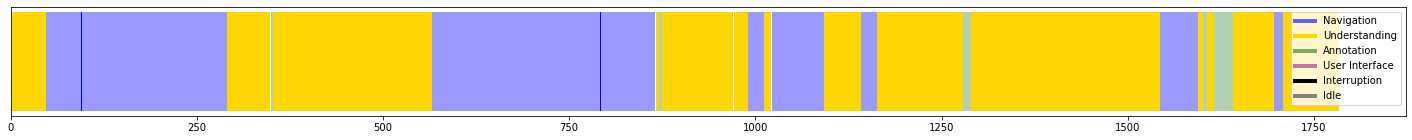

<Figure size 1800x144 with 0 Axes>

In [19]:
from matplotlib.lines import Line2D

plt.figure(figsize=(25,2))
colors_dur = {'user interface': purple_op,'navigation': blue_op,'editing': green_op, 'interruption':'black', 'understanding': underst, 'idle':'grey', 'start': yellow, 'end': yellow}
colors_points = {'user interface': purple,'navigation': blue,'editing': green, 'interruption':'black', 'understanding': underst, 'idle':'grey', 'start': yellow, 'end': yellow}
colors_act = {'user interface': purple_act,'navigation': blue_act,'editing': green_act, 'interruption':'black', 'understanding': underst, 'idle':'grey', 'start': yellow, 'end': yellow}

custom_lines = [
                Line2D([0], [0], color=colors_dur['navigation'] , lw=4),
                Line2D([0], [0], color=underst, lw=4),
                Line2D([0], [0], color=colors_dur['editing'] , lw=4),
                Line2D([0], [0], color=colors_dur['user interface'] , lw=4),
                Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color=yellow, lw=4)
               ]

for user in df_dur.user.unique():
    df_items = df_dur[(df_dur.user == user)]
    start = df_items.time.min()
    end = df_items.time_dup.max()

    df_act = df_activity[(df_activity.user == user)]
    df_act['rel_start'] = df_act.time.apply(lambda x: (x-start).seconds)
    
    
    for i, row in df_act.iterrows():
        plt.barh(y=row.user, left=row.rel_start, 
                 width = row.delta, 
                 color=colors_act[row['action_category']]
                 )
        
    df_items['rel_start'] = df_items.time.apply(lambda x: (x-start).seconds)

    for i, row in df_items.iterrows():
        if row['delta'] == 0:
            plt.barh(y=row.user, left = row.rel_start, 
                     width =  0.1, 
                     color = colors_points[row['action_category']]
                     )
        else:
            plt.barh(y = row.user, left = row.rel_start, 
                 width = row.delta, 
                 color = colors_dur[row['action_category']]
                 )
    plt.yticks([])
    plt.legend(custom_lines, [ 'Navigation', 'Understanding', 'Annotation', 'User Interface', 'Interruption', 'Idle', #'Start'
                             ])
#     plt.title("participant: " + user + " group: " + dict_users[user])
    
    plt.savefig('../figures/' + user + '_' + dict_users[user] + "_activity_plot.pdf", bbox_inches='tight')
    plt.show()
    plt.figure(figsize=(25,2))

In [20]:
df_dur = pd.merge(df_dur, df_users[['user', 'group']], left_on='user', right_on='user', how='left')
df_activity = pd.merge(df_activity, df_users[['user', 'group']], left_on='user', right_on='user', how='left')

In [21]:
df_idel_dur = df_dur[df_dur.action_category.isin(['idle'])].groupby(['user', 'group'])['delta'].sum().reset_index(name='idle_time')
df_idel_dur['idle_time'] = df_idel_dur['idle_time']/60

df_interrupt = df_interruptions.groupby('user')['interrupt_duration'].sum().reset_index()
df_interrupt['duration_interruption'] = df_interrupt['interrupt_duration']

In [22]:
df_act_stat = df_dur[df_dur['action_category'] == 'understanding']
df_act_stat = df_act_stat.groupby(['user', 'group'])['delta'].sum().reset_index(name='duration')
df_act_stat['duration'] = df_act_stat['duration']/60
df_act_stat['activity'] = 'understanding'

In [23]:
df_act_stat = pd.merge(df_act_stat, df_times[['user', 'total_duration']], left_on='user', right_on='user', how='left')
df_act_stat = pd.merge(df_act_stat, df_interrupt[['user', 'duration_interruption']], left_on='user', right_on='user', how='left').fillna(0)
df_act_stat = pd.merge(df_act_stat, df_idel_dur[['user', 'idle_time']], left_on='user', right_on='user', how='left').fillna(0)

In [24]:
df_temp = df_activity[df_activity['action_category'].isin(['navigation', 'user interface', 'editing'])]
df_temp = df_temp.groupby(['user', 'group', 'action_category'])['delta'].sum().reset_index(name='duration')
df_temp['duration'] = df_temp['duration']/60

In [25]:
df_temp = pd.merge(df_temp, df_times[['user', 'total_duration']], left_on='user', right_on='user', how='left')
df_temp = pd.merge(df_temp, df_interrupt[['user', 'duration_interruption']], left_on='user', right_on='user', how='left').fillna(0)
df_temp = pd.merge(df_temp, df_idel_dur[['user', 'idle_time']], left_on='user', right_on='user', how='left').fillna(0)

In [26]:
df_temp['activity'] = df_temp['action_category']
df_temp = df_temp[['user', 'group', 'duration', 'total_duration', 'duration_interruption', 'idle_time', 
                   'activity']]

In [27]:
df_act_stat = pd.concat([df_act_stat, df_temp])

In [28]:
df_act_stat['ratio'] = (df_act_stat['duration']/(df_act_stat['total_duration']
                                                 - df_act_stat['duration_interruption'] 
                                                 - df_act_stat['idle_time'])) * 100

In [29]:
df_pivot = df_act_stat.pivot(index='user', columns='activity', values='duration').reset_index().fillna(0)
df_pivot['total'] = df_pivot['understanding'] + df_pivot['editing'] + df_pivot['navigation'] + df_pivot['user interface']
df_pivot = pd.merge(df_pivot, df_users[['user', 'group']], left_on='user', right_on='user', how='left')

In [30]:
df_pivot['understanding'] = df_pivot['understanding'].apply(lambda  l: round(l,2))
df_pivot['editing'] = df_pivot['editing'].apply(lambda  l: round(l,2))
df_pivot['navigation'] = df_pivot['navigation'].apply(lambda  l: round(l,2))
df_pivot['user interface'] = df_pivot['user interface'].apply(lambda  l: round(l,2))
df_pivot['total'] = df_pivot['total'].apply(lambda  l: round(l,2))

In [31]:
df_pivot['group_bin'] = df_pivot.group.apply(lambda l: 1 if l =='canvas' else 0) 

In [32]:
df_pivot

user  editing  navigation  understanding  user interface   total  \
0        aqua     4.18       11.42          17.20            0.64   33.44   
1      beluga     8.06        5.84          36.21            1.47   51.58   
2      binder     3.32        9.88          13.90            2.38   29.48   
3       bread    14.99        3.66          32.61            4.08   55.34   
4      cement     2.35        3.60          16.47            0.62   23.05   
5     channel     2.75        3.17          12.57            0.55   19.04   
6      cloudy     4.79       42.32          56.17            3.10  106.37   
7       drive     5.70       17.91          33.74           11.36   68.71   
8      energy     2.79       29.89          19.03            0.58   52.28   
9       epoch     2.81       15.71          29.15            5.23   52.90   
10      frame    10.21        4.93          22.45            3.44   41.03   
11  handshake     1.25        5.40          12.34            4.17   23.17   
12    holiday     2.87       17.55          20.46            1.07   41.94   
13       noon     7.32       11.05          31.52            2.89   52.78   
14      north     0.00       14.02          32.19            6.83   53.03   
15     outfit     4.14        9.25          22.36            2.05   37.79   
16        owl     0.12       19.66          17.65            0.72   38.14   
17      patch     0.73       13.20          16.82            1.58   32.33   
18       soup     8.46       12.42          15.51            2.12   38.51   
19     valley     0.81       12.02          16.92            0.00   29.75   

      group  group_bin  
0   control          0  
1   control          0  
2    canvas          1  
3    canvas          1  
4    canvas          1  
5    canvas          1  
6   control          0  
7   control          0  
8   control          0  
9    canvas          1  
10   canvas          1  
11  control          0  
12   canvas          1  
13   canvas          1  
14  control          0  
15  control          0  
16   canvas          1  
17  control          0  
18   canvas          1  
19  control          0